# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

In [ ]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6559, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 6559 (delta 45), reused 35 (delta 35), pack-reused 6293
Receiving objects: 100% (6559/6559), 116.26 MiB | 15.21 MiB/s, done.
Resolving deltas: 100% (275/275), done.
Updating files: 100% (5717/5717), done.


In [ ]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [ ]:
class GroceryStoreDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1


In [ ]:
from torchvision import transforms as T
from torchvision.transforms import ToTensor

tsfms = T.Compose([
    T.ToTensor(),
    T.Resize((256, 256)),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
train_dataset = GroceryStoreDataset(split="train", transform = tsfms)
test_dataset = GroceryStoreDataset(split="test", transform = tsfms)
val_dataset = GroceryStoreDataset(split="val", transform = tsfms)

In [ ]:
from torch.utils.data import random_split, DataLoader

batch_size = 16

train_dl = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_dl = DataLoader(
    val_dataset,
    batch_size=batch_size
)
test_dl = DataLoader(
    test_dataset,
    batch_size=batch_size
)

In [ ]:
original_shape = train_dataset[0][0].shape

print("Original image shape:", original_shape)

Original image shape: torch.Size([3, 256, 256])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

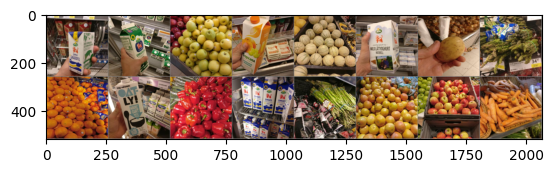

In [ ]:
dataiter = iter(train_dl)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [ ]:
conv1 = nn.Conv2d(3,6,3)
pool = nn.MaxPool2d(2,2)
conv2 = nn.Conv2d(6,16,3)
fc1 = nn.Linear(16*5*5, 120)
x1 = conv1(images)
x2 = pool(x1)
x3 = conv2(x2)
x4= pool(x3)
#x = fc1(x)
x1 = conv1(images)
x2 = pool(x1)
x3 = conv2(x2)
x4 = pool(x3)

print("Input images shape:", images.shape)
print("Conv1 output shape:", x1.shape)
print("MaxPool1 output shape:", x2.shape)
print("Conv2 output shape:", x3.shape)
print("MaxPool2 output shape:", x4.shape)

Input images shape: torch.Size([16, 3, 256, 256])
Conv1 output shape: torch.Size([16, 6, 254, 254])
MaxPool1 output shape: torch.Size([16, 6, 127, 127])
Conv2 output shape: torch.Size([16, 16, 125, 125])
MaxPool2 output shape: torch.Size([16, 16, 62, 62])


In [ ]:
images.shape

torch.Size([16, 3, 256, 256])

In [ ]:
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)  # Reduced number of filters and kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)  # Reduced number of filters and kernel size
        self.fc1 = nn.Linear(16 * 62 * 62, 64)  # Reduced number of units
        self.fc2 = nn.Linear(64, 32)  # Reduced number of units
        self.fc3 = nn.Linear(32, 43)
        self.dropout = nn.Dropout(0.5)  # Dropout layer with 50% probability

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 62 * 62)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Applying dropout after the first fully connected layer
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # Applying dropout after the second fully connected layer
        x = self.fc3(x)
        return x


In [ ]:
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 62 * 62, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 43)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 62 * 62)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
model = ConvNet().to(device)

In [ ]:
model

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=246016, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=43, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
n_total_steps = len(train_dl)
print_frequency = 100

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dl):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % print_frequency == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

    model.eval()
    n_correct = 0
    n_samples = 0
    for images, labels in test_dl:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    accuracy = 100.0 * n_correct / n_samples
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {accuracy:.2f}%, Loss: {loss.item():.4f}')
    model.train()  # Set model back to training mode

print('Finished Training')
torch.save(model.state_dict(), 'best_model.pth')


Epoch [1/10], Step [100/165], Loss: 3.4653
Epoch [1/10], Validation Accuracy: 16.38%, Loss: 3.5351
Epoch [2/10], Step [100/165], Loss: 3.7320
Epoch [2/10], Validation Accuracy: 18.91%, Loss: 3.4557
Epoch [3/10], Step [100/165], Loss: 3.2206
Epoch [3/10], Validation Accuracy: 18.39%, Loss: 2.8501
Epoch [4/10], Step [100/165], Loss: 2.6873
Epoch [4/10], Validation Accuracy: 18.35%, Loss: 3.1597
Epoch [5/10], Step [100/165], Loss: 2.6487
Epoch [5/10], Validation Accuracy: 24.39%, Loss: 2.6112
Epoch [6/10], Step [100/165], Loss: 2.3947
Epoch [6/10], Validation Accuracy: 25.07%, Loss: 2.9213
Epoch [7/10], Step [100/165], Loss: 1.9278
Epoch [7/10], Validation Accuracy: 29.54%, Loss: 1.9948
Epoch [8/10], Step [100/165], Loss: 1.8083
Epoch [8/10], Validation Accuracy: 28.89%, Loss: 2.2998
Epoch [9/10], Step [100/165], Loss: 2.3861
Epoch [9/10], Validation Accuracy: 29.66%, Loss: 2.2668
Epoch [10/10], Step [100/165], Loss: 2.2209
Epoch [10/10], Validation Accuracy: 30.38%, Loss: 2.0406
Finished